# Credit Card Fraud Detection
This project is initiated to analyze anonimized dataset provided by **Machine Learning Group - ULB** at Kaggle [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since the data is anonymized and doesn't describe time-related relation between each data, we will disregard time series analysis. So, in this project, the data will be analyzed (disregarding time series) to create a model using:
- Artificial Neural Network

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import recall_score

Using TensorFlow backend.


### Initiate Setup

In [2]:
%matplotlib inline
np.seed = 0

evaluation_portion = 0.2
outlier_percentile = 0.05
dataset_location = './data/creditcard.csv'

### Load Data
Let's load the data using `pandas` to ease our work.

In [3]:
data = pd.read_csv(dataset_location)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Since we decided to disregard `Time` feature, let's drop it from the data. And since the value in feature `Amount` are way higher than the others, we will need to normalize it.

In [4]:
if 'Time' in data:
    data = data.drop(columns=['Time'])
data['Amount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Since the data contains class, we will create model using classification algorithm. But, before we do that, in this project we will split the data into two parts based on portion. The part with higher portion will be treated as *data set* while the other is treated as *data evaluation*. Let's set the portion to be 80% for data set and 20% for data evaluation.

In [5]:
data_set, data_evaluation = train_test_split(data, test_size = evaluation_portion)
data_set = data_set.sort_index()
data_evaluation = data_evaluation.sort_index()

### Draw Figure

Now that we have split the data, let's put *data evaluation* aside and focus on *data set*.<br>
In order to help us understand the "shape" of data we have, let's create figure representing data from each feature. Since we have two classes, let's separate them and draw the figure side by side. (For the shake of simplicity, the figure shown is only for two features.)

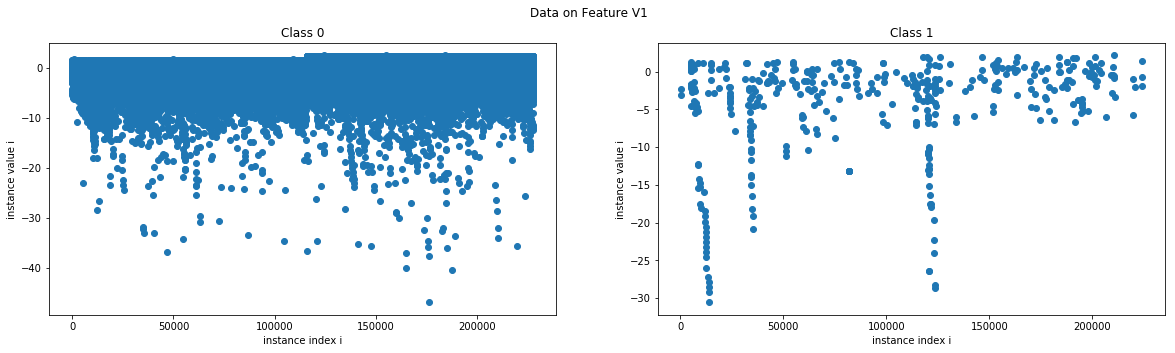

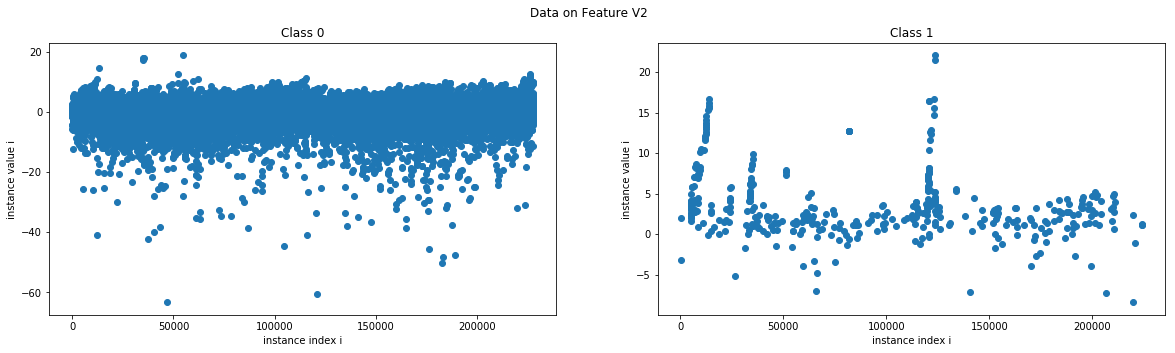

In [6]:
limit_figure = 2

name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
for i in range(len(feature_names)):
    if i == len(feature_names)-1:
        continue
    if i >= limit_figure:
        break
    fig = plt.figure(figsize=[20, 5])
    fig.suptitle('Data on Feature {0}'.format(feature_names[i]))
    for j in range(len(name_of_class)):
        y_raw = data_set.iloc[class_ix[name_of_class[j]],i]
        x = data_ix[name_of_class[j]]
        position = int('1{0}{1}'.format(len(name_of_class),j+1))
        ax = fig.add_subplot(position)
        ax.scatter(x, y_raw)
        ax.set_title('Class {0}'.format(name_of_class[j]))
        ax.set_xlabel('instance index i')
        ax.set_ylabel('instance value i')
    plt.show()
    del fig

### Clean Outlier

As we can see from the figures above, there are some values that's way lower or higher than the average data. This may lead to outlier problem. There are some techniques we can use, such as:
* Winsorize
* Tukey's method
* Minkowski error
* Uni- and multi-variate analysis

Since this is the init of the project, we will use Winsorize technique as will the other techniques later. Let's set the percentile value to be 5%.

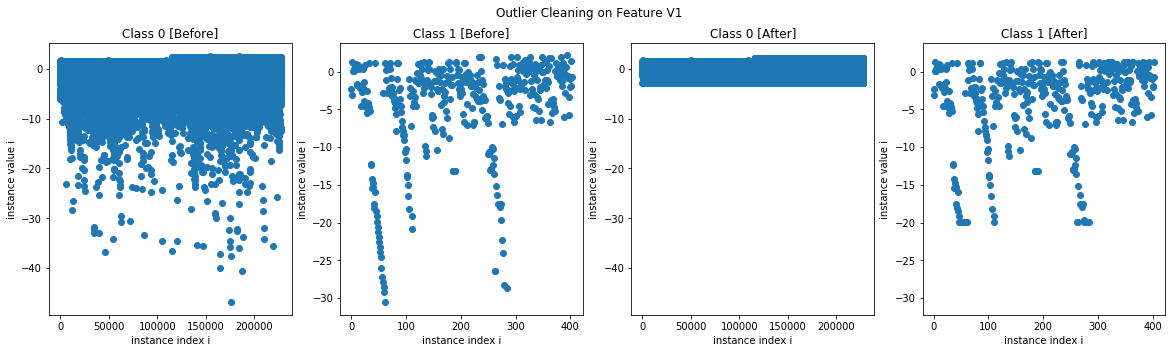

Feature V1 is processed


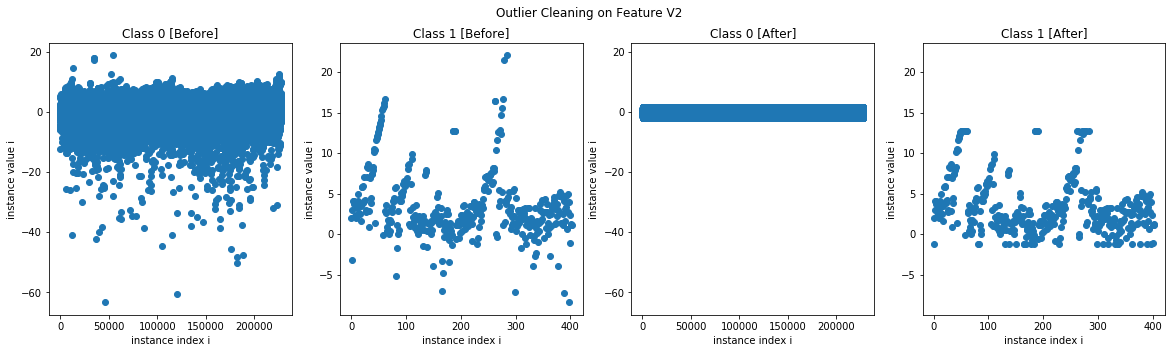

Feature V2 is processed


In [7]:
limit_figure = 2

name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(class_ix[name_of_class[i]]))]

data_set_outlier_cleaned = data_set.copy()
for i in range(len(feature_names)):
    if i == len(feature_names)-1:
        break
    temp_data = np.array(data_set_outlier_cleaned.loc[:,feature_names[i]])
    if i < limit_figure:
        fig = plt.figure(figsize=[20,5])
        fig.suptitle('Outlier Cleaning on Feature {0}'.format(feature_names[i]))
    for j in range(len(name_of_class)):
        y_raw = temp_data[class_ix[name_of_class[j]]]
        x = data_ix[name_of_class[j]]
        if i < limit_figure:
            position = int('1{0}{1}'.format(len(name_of_class)*2,j+1))
            ax0 = fig.add_subplot(position)
            ax0.scatter(x, y_raw)
            ax0.set_title('Class {0} [Before]'.format(name_of_class[j]))
            ax0.set_xlabel('instance index i')
            ax0.set_ylabel('instance value i')
        y_cleaned = scipy.stats.mstats.winsorize(y_raw, limits = outlier_percentile)
        if i < limit_figure:
            position = int('1{0}{1}'.format(len(name_of_class)*2,j+1+len(name_of_class)))
            ax1 = fig.add_subplot(position, sharey = ax0)
            ax1.scatter(x, y_cleaned)
            ax1.set_title('Class {0} [After]'.format(name_of_class[j]))
            ax1.set_xlabel('instance index i')
            ax1.set_ylabel('instance value i')
        temp_data[class_ix[name_of_class[j]]] = y_cleaned
    del data_set_outlier_cleaned[feature_names[i]]
    data_set_outlier_cleaned[feature_names[i]] = temp_data
    if i < limit_figure:
        plt.show()
        del fig
        print('Feature {0} is processed'.format(feature_names[i]))
data_set_outlier_cleaned = data_set_outlier_cleaned.reset_index()
del data_set_outlier_cleaned['index']

### Imbalanced class

In [8]:
def print_frequency(data_class):
    name_of_class, number_of_class = np.unique(data_class, return_counts = True)
    size_before = np.array(number_of_class, dtype = float) / np.sum(number_of_class)
    explode = (number_of_class == number_of_class.min()) * 0.2

    fig = plt.figure(figsize=[15,5])
    fig.suptitle('Frequency of Class')
    ax0 = fig.add_subplot('121')
    ax0.pie(size_before, explode = explode, labels = name_of_class, autopct = '%1.1f%%',
          shadow = True, startangle = 45)
    ax0.legend(number_of_class, loc = 'lower right')

    ax1 = fig.add_subplot('122')
    ax1.set_ylabel('Frequency of Class')
    ax1.set_xlabel('Class Label')
    ax1.bar(name_of_class[0], height=number_of_class[0], color='b', label='0')
    ax1.bar(name_of_class[1], height=number_of_class[1], color='y', label='1')
    ax1.set_xticks(name_of_class)
    ax1.set_xticklabels(name_of_class)
    ax1.legend(number_of_class, loc = 'lower right')

    plt.show()

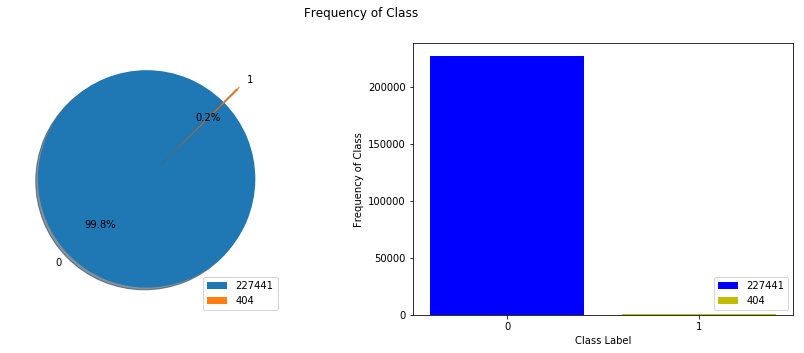

In [9]:
print_frequency(data_set_outlier_cleaned.loc[:,'Class'])

As we can see, there area two classes in dataset named class `0` and class `1`. If we look at the frequency of class before cleaning, the number of class `0` is way higher than class `1`. This clearly shows that the dataset contains imbalanced class problem.

There are some possible solutions we can use:
* 1. Collect more data
* 2. Under sampling
* 3. Over sampling
* 4. Combination of under and over sampling

In **Clean Outlier** section, the data I deleted are the one that contains outlier in at least one feature. It's true that there is possibility that important informations lie there despite the outlier on certain feature.

In [10]:
data_set_x = np.array(data_set_outlier_cleaned.iloc[:,1:])
data_set_y = np.array(data_set_outlier_cleaned.iloc[:,0])

In [11]:
smote_enn = SMOTEENN()
x_resampled, y_resampled = smote_enn.fit_resample(data_set_x, data_set_y)

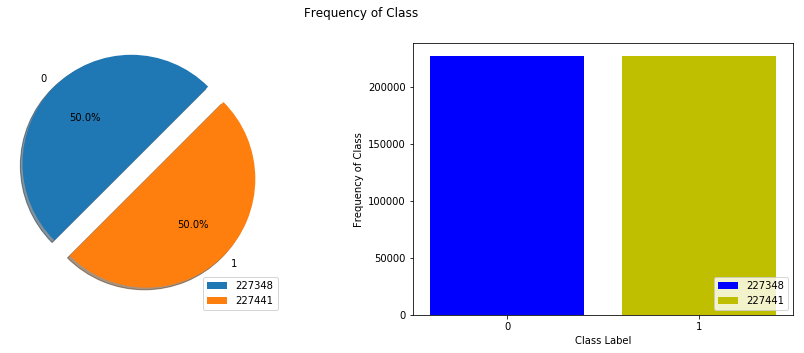

In [12]:
print_frequency(y_resampled)

In [19]:
scaler_model = StandardScaler()
scaler_model.fit(x_resampled)

x_rescaled = scaler_model.transform(x_resampled)

In [20]:
number_of_k = 10

ann_model = MLPClassifier(hidden_layer_sizes=[100,100,100])
stratified_k_fold = StratifiedKFold(n_splits=number_of_k)
i = 0
for train_index, test_index in stratified_k_fold.split(x_rescaled, y_resampled):
    x_train, y_train = x_rescaled[train_index], y_resampled[train_index]
    x_test, y_test = x_rescaled[test_index], y_resampled[test_index]
    
    ann_model.fit(x_train, y_train)
    y_predict = ann_model.predict(x_test)
    
    i += 1
    print()
    print('itration ({0}/{1})'.format(i, number_of_k))
    print('recall: {0}'.format(recall_score(y_test, y_predict)))
    break


itration of (1/10)
recall: 1.0


In [21]:
x_evaluation, y_evaluation = np.array(data_evaluation.iloc[:,:-1]), np.array(data_evaluation.iloc[:,-1])
x_evaluation = scaler_model.transform(x_evaluation)
y_prediction = ann_model.predict(x_evaluation)

print()
print('evaluation')
print('recall: {0}'.format(recall_score(y_evaluation, y_prediction)))


evaluation
recall: 0.8863636363636364


In [107]:
number_of_k = 10

stratified_k_fold = StratifiedKFold(n_splits=number_of_k)
for train_index, test_index in stratified_k_fold.split(x_rescaled, y_resampled):
    x_train, y_train = x_rescaled[train_index], y_resampled[train_index]
    x_test, y_test = x_rescaled[test_index], y_resampled[test_index]
    
    train_shape = np.shape(x_train)
    seq_model = Sequential()
    seq_model.add(Dense(units=29, activation='tanh', input_dim=train_shape[1]))
    seq_model.add(Dense(units=128, activation='softmax'))
    seq_model.add(Dense(units=128, activation='relu'))
    seq_model.add(Dense(units=1, activation='relu'))
    seq_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    seq_model.fit(x_train, y_train, epochs=3, batch_size=1000)
    y_predict = seq_model.predict(x_test)
    
    print()
    print('acc: {0}'.format(sum(y_predict.reshape(1,-1)[0]==y_test)/float(len(y_predict))))
    break

Epoch 1/3
409345/409345 [==============================] - 3s 6us/step - loss: nan - acc: 0.4999
Epoch 2/3
409345/409345 [==============================] - 2s 4us/step - loss: nan - acc: 0.4999
Epoch 3/3
409345/409345 [==============================] - 2s 4us/step - loss: nan - acc: 0.4999

acc: 0.4999230481718444
